In [1]:
from utils import *

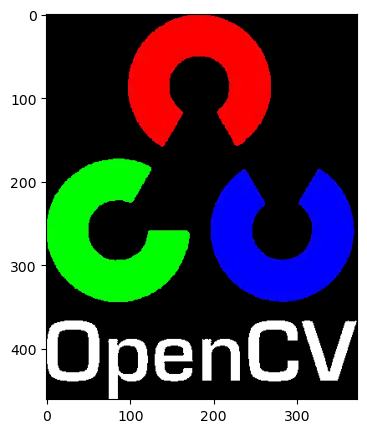

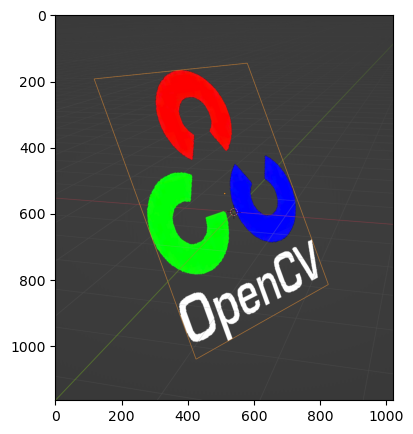

In [2]:
img_1 = readImage('./input/opencv.png')
img_2 = readImage('./input/perspect_test.png')
showImage(img_1)
showImage(img_2)

In [3]:
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img_1, None)
kp2, des2 = orb.detectAndCompute(img_2, None)
len(kp1), len(kp2)

(437, 500)

In [4]:
bf = cv.BFMatcher_create(cv.NORM_HAMMING, True)
matches = bf.match(des1, des2)
matched = sorted(matches, key=lambda x: x.distance)
len(matches)

95

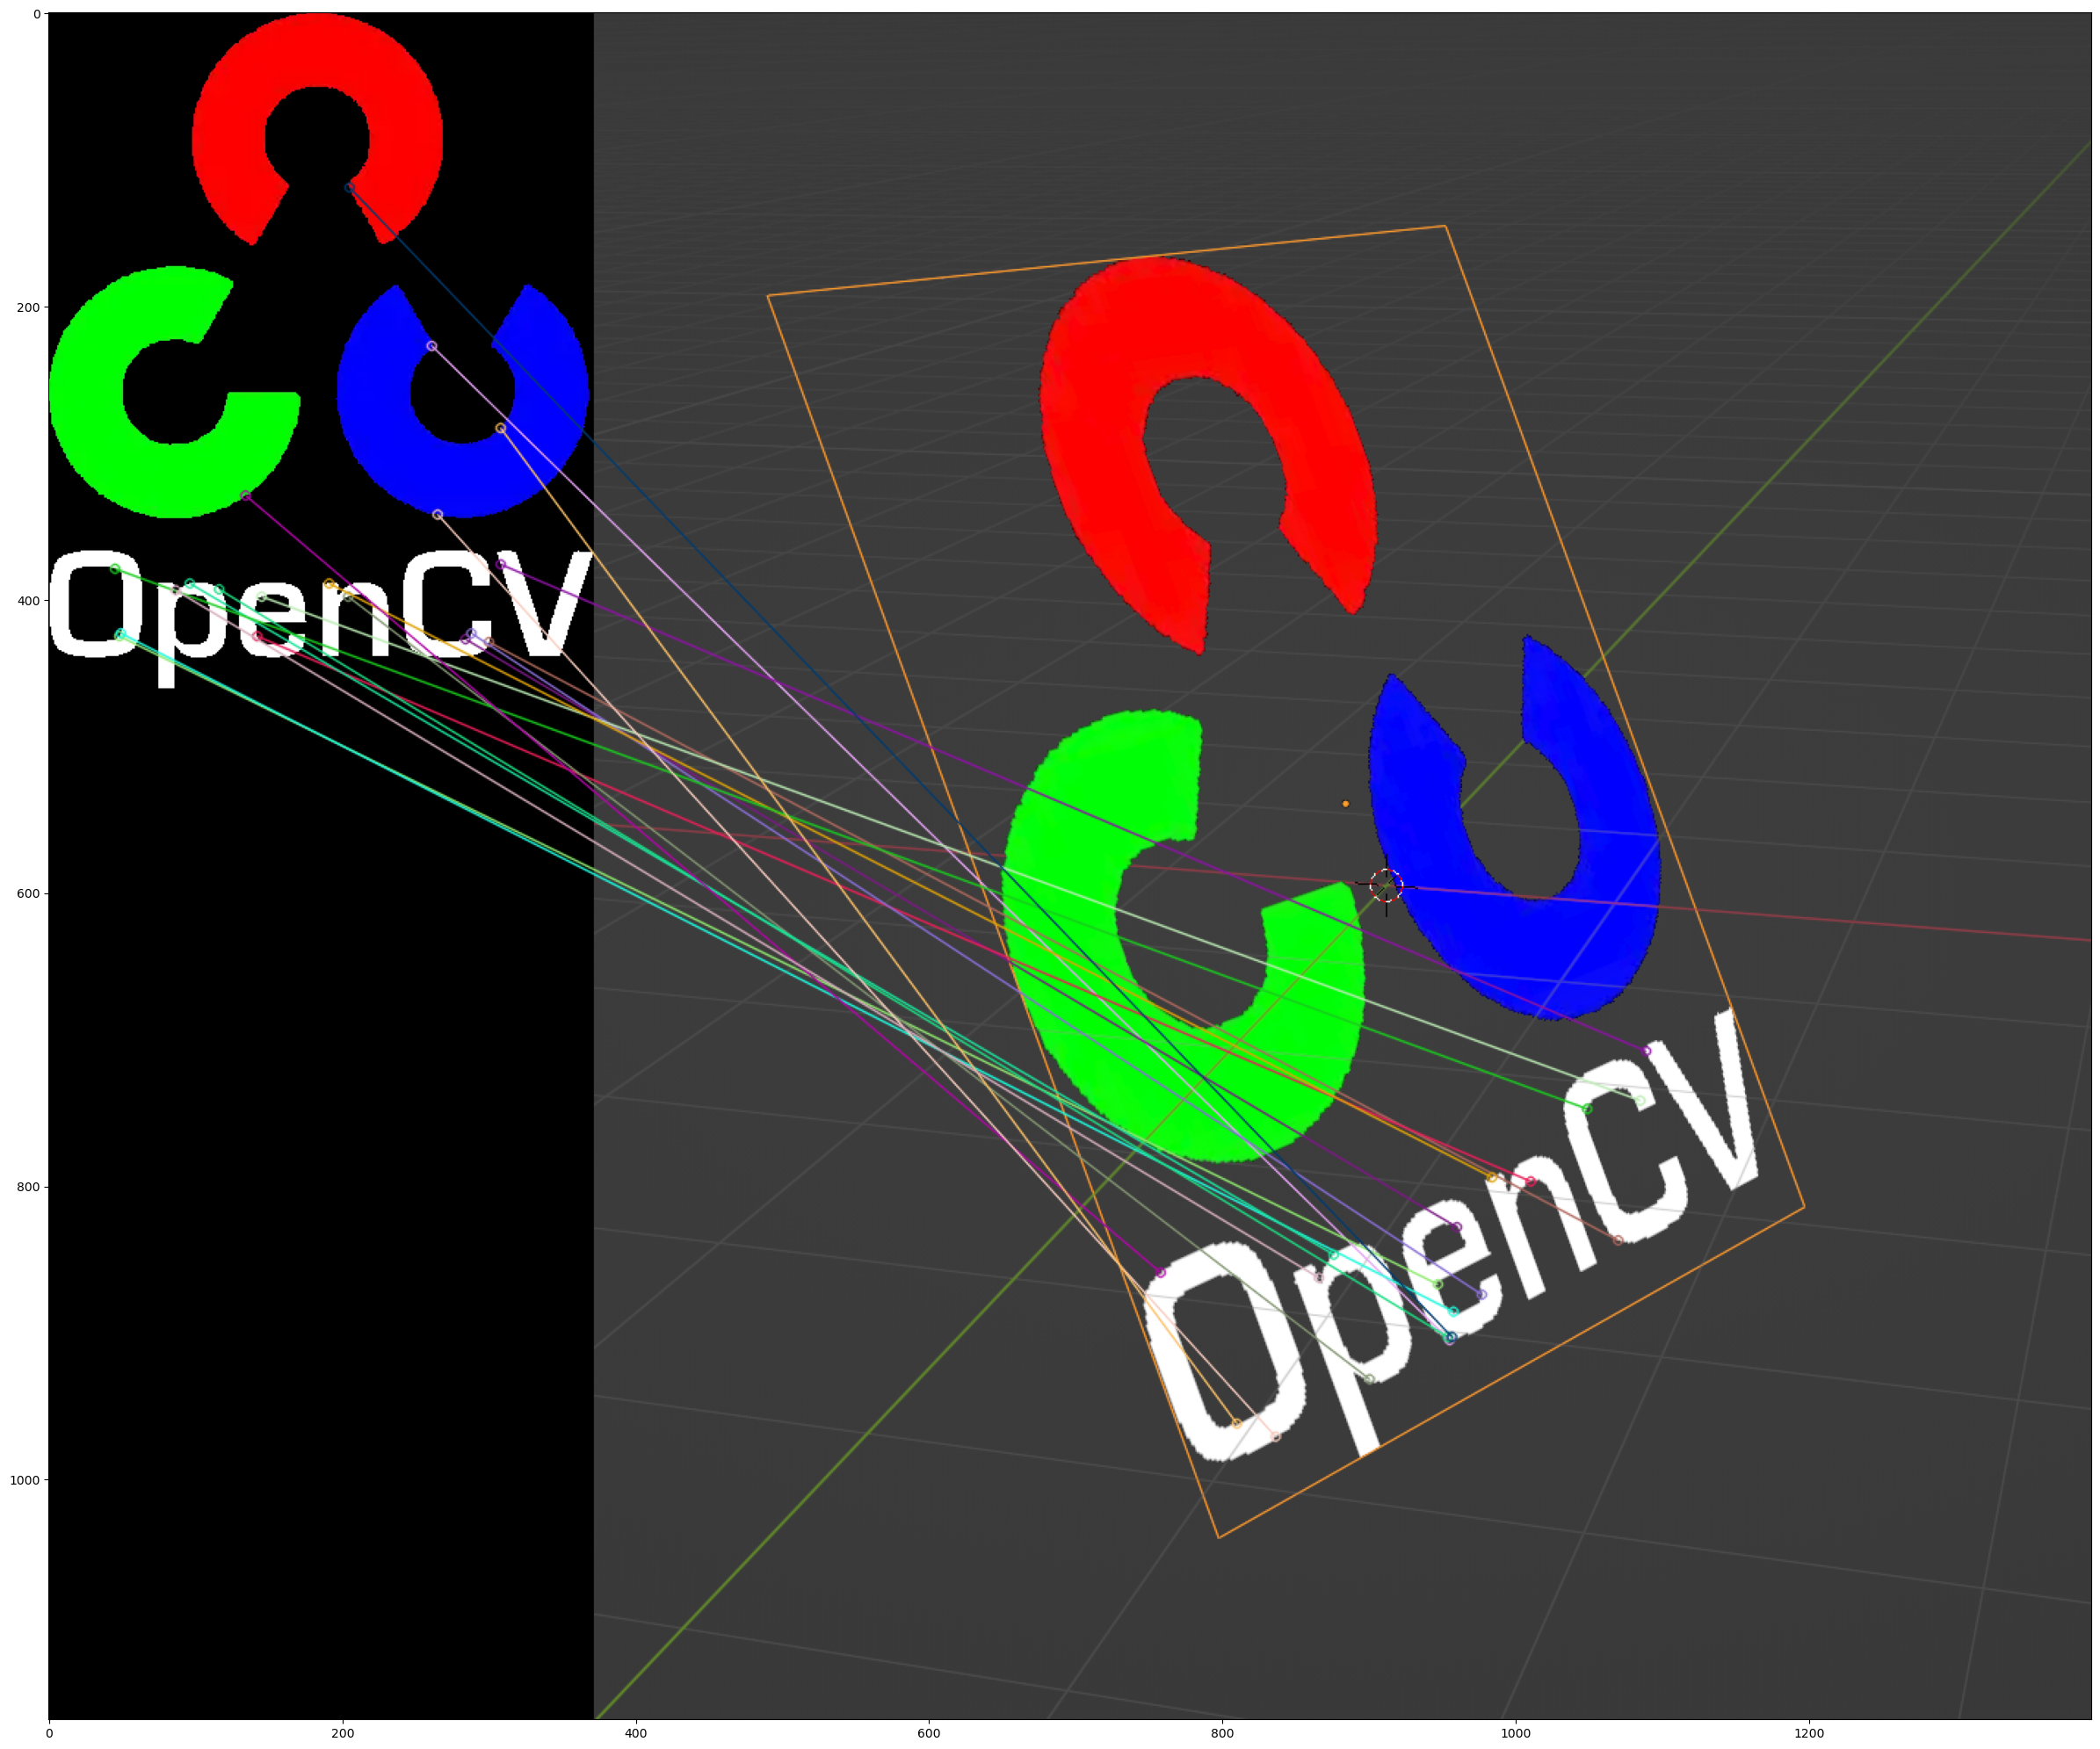

In [5]:
dest = cv.drawMatches(img_1, kp1, img_2, kp2, matches[:int(len(matched)*0.2)], None, flags=2)
showImage(dest, figsize=(30, 30))

In [7]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)   # 或传递一个空字典

In [8]:
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

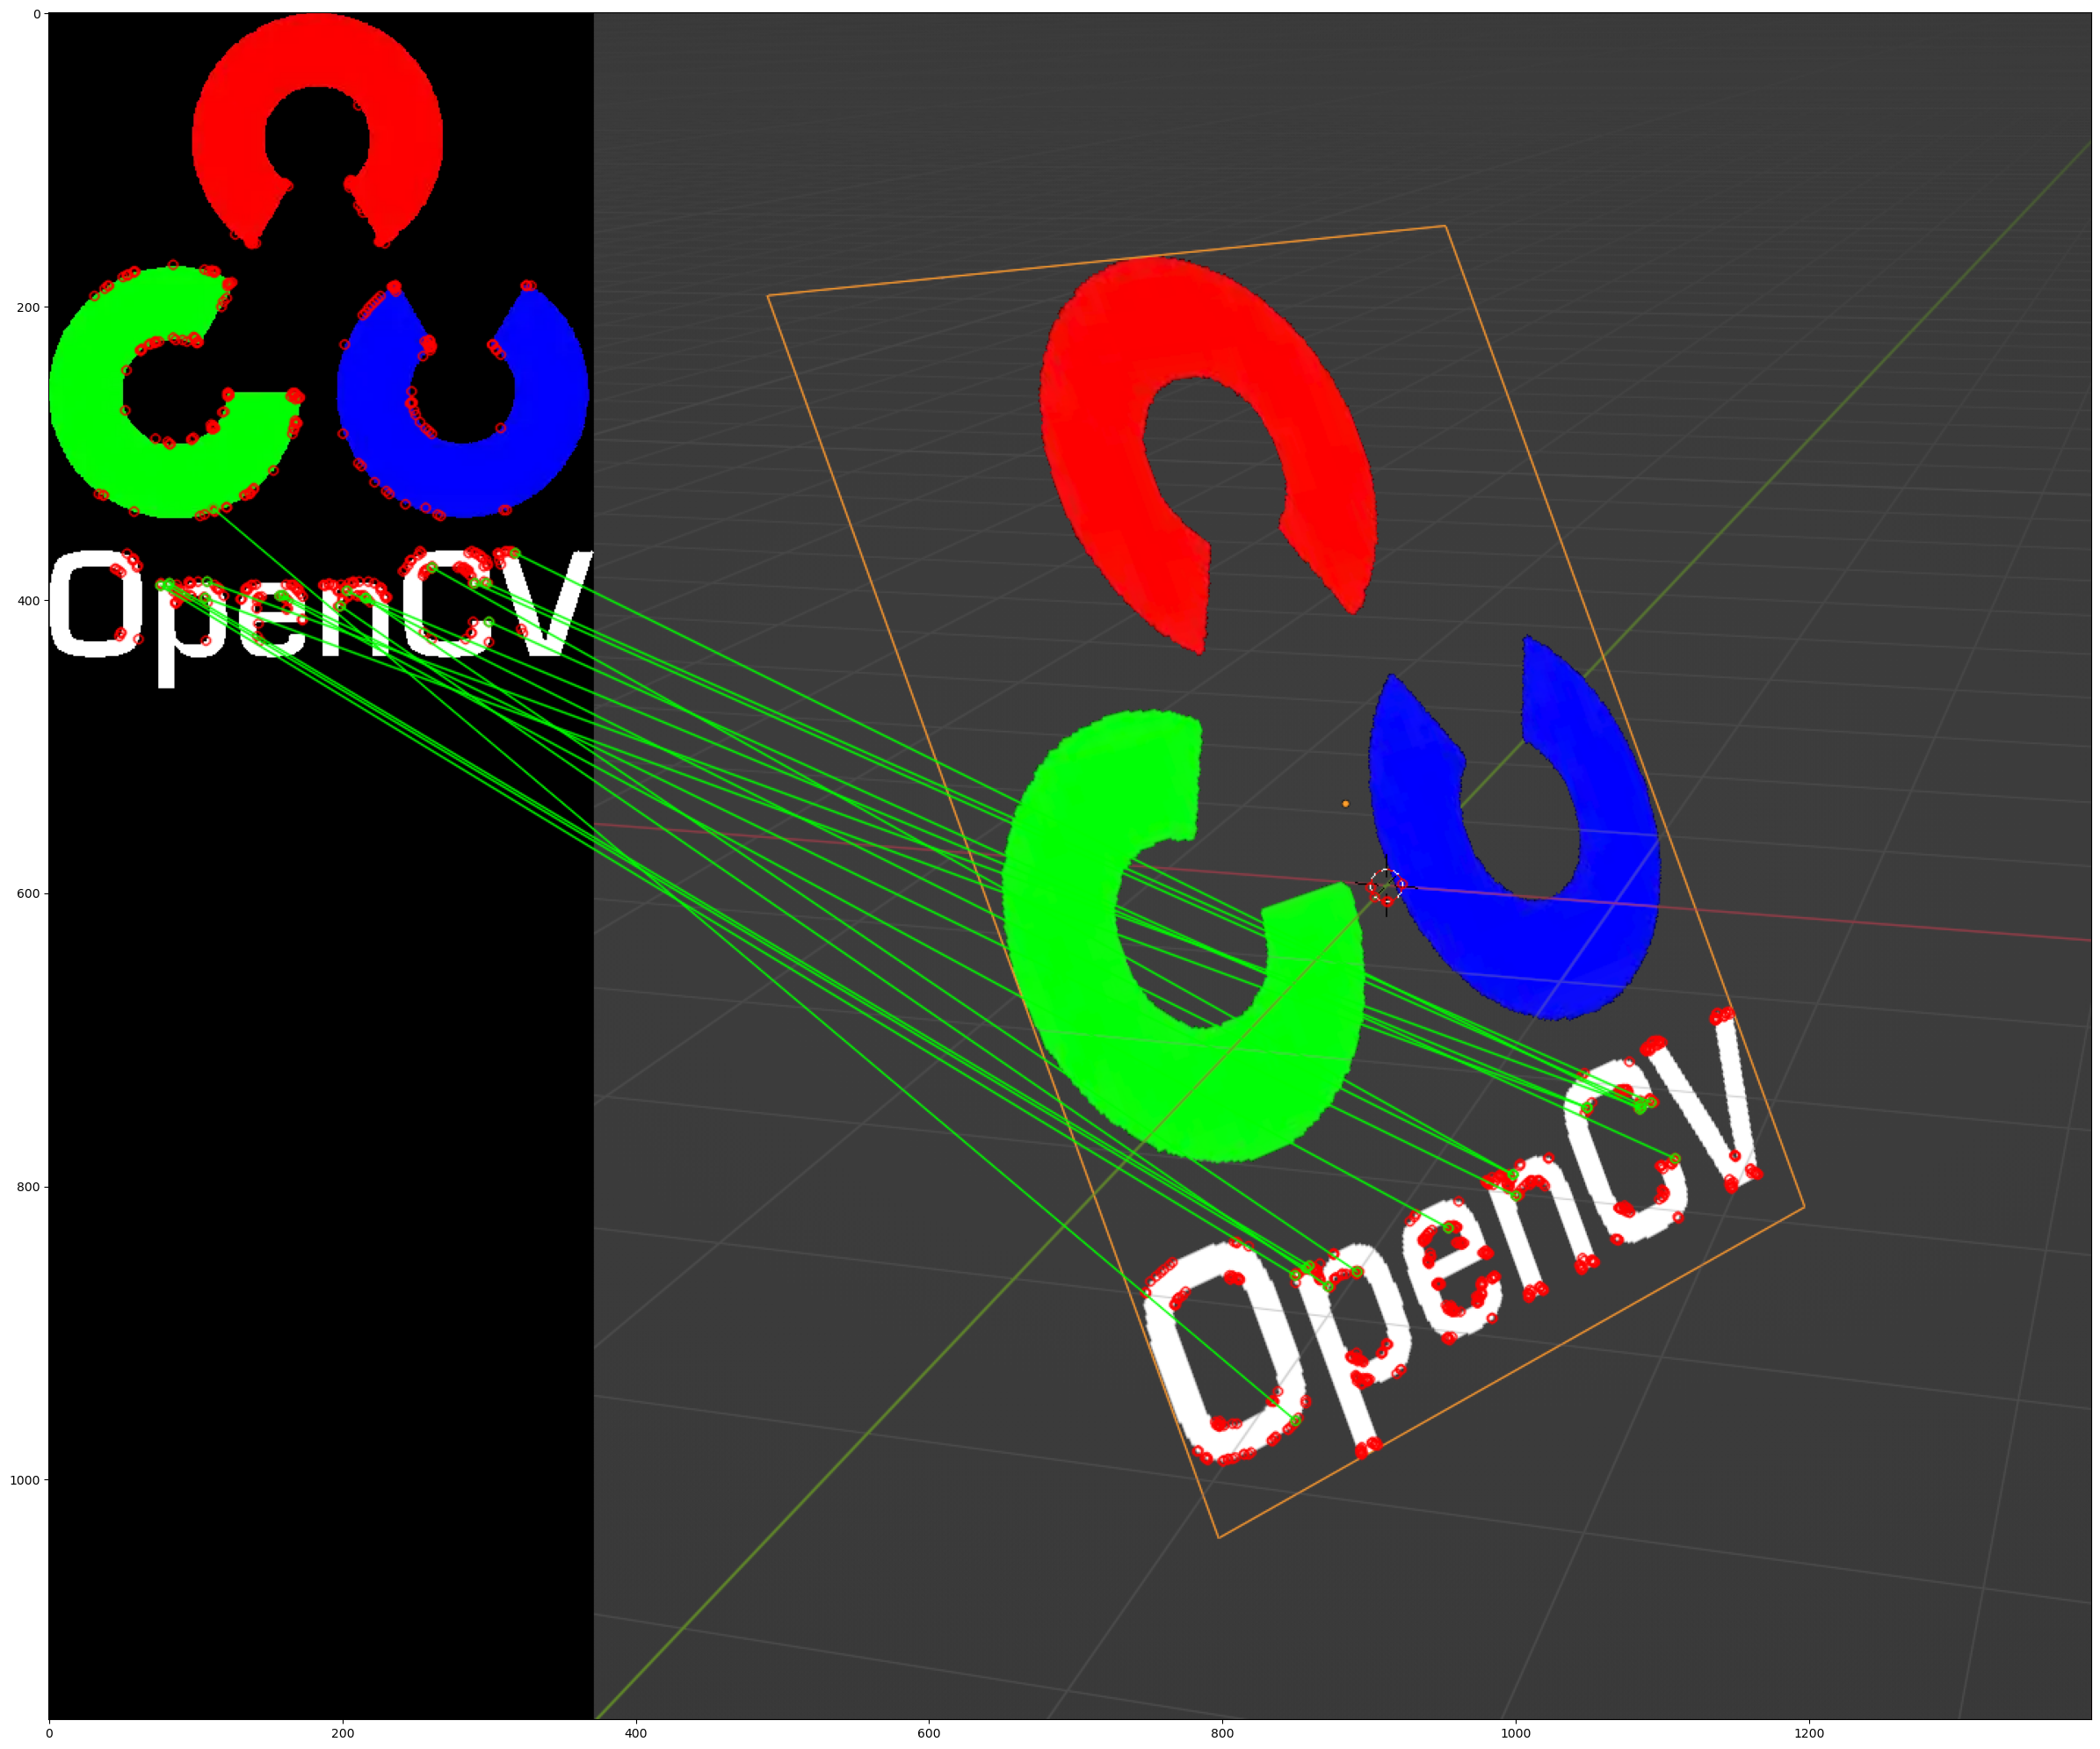

In [10]:
# 只需要绘制好匹配项，因此创建一个掩码
matchesMask = [[0,0] for i in range(len(matches))]
# 根据Lowe的论文进行比例测试
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
dest = cv.drawMatchesKnn(img_1,kp1,img_2,kp2,matches,None,**draw_params)
showImage(dest, figsize=(30, 30))

In [15]:
sift = cv.SIFT().create()
# 用SIFT找到关键点和描述符
kp1, des1 = sift.detectAndCompute(img_1,None)
kp2, des2 = sift.detectAndCompute(img_2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# ＃根据Lowe的比率测试存储所有符合条件的匹配项。
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [19]:
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img_1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    dest = cv.polylines(img_2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

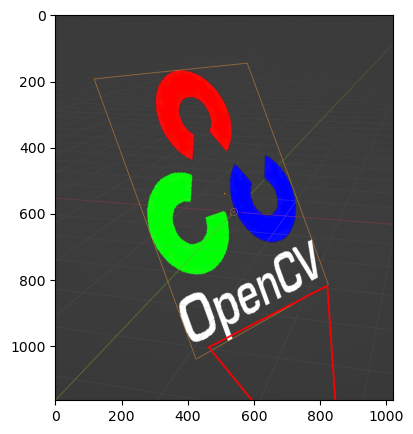

In [21]:
showImage(dest)

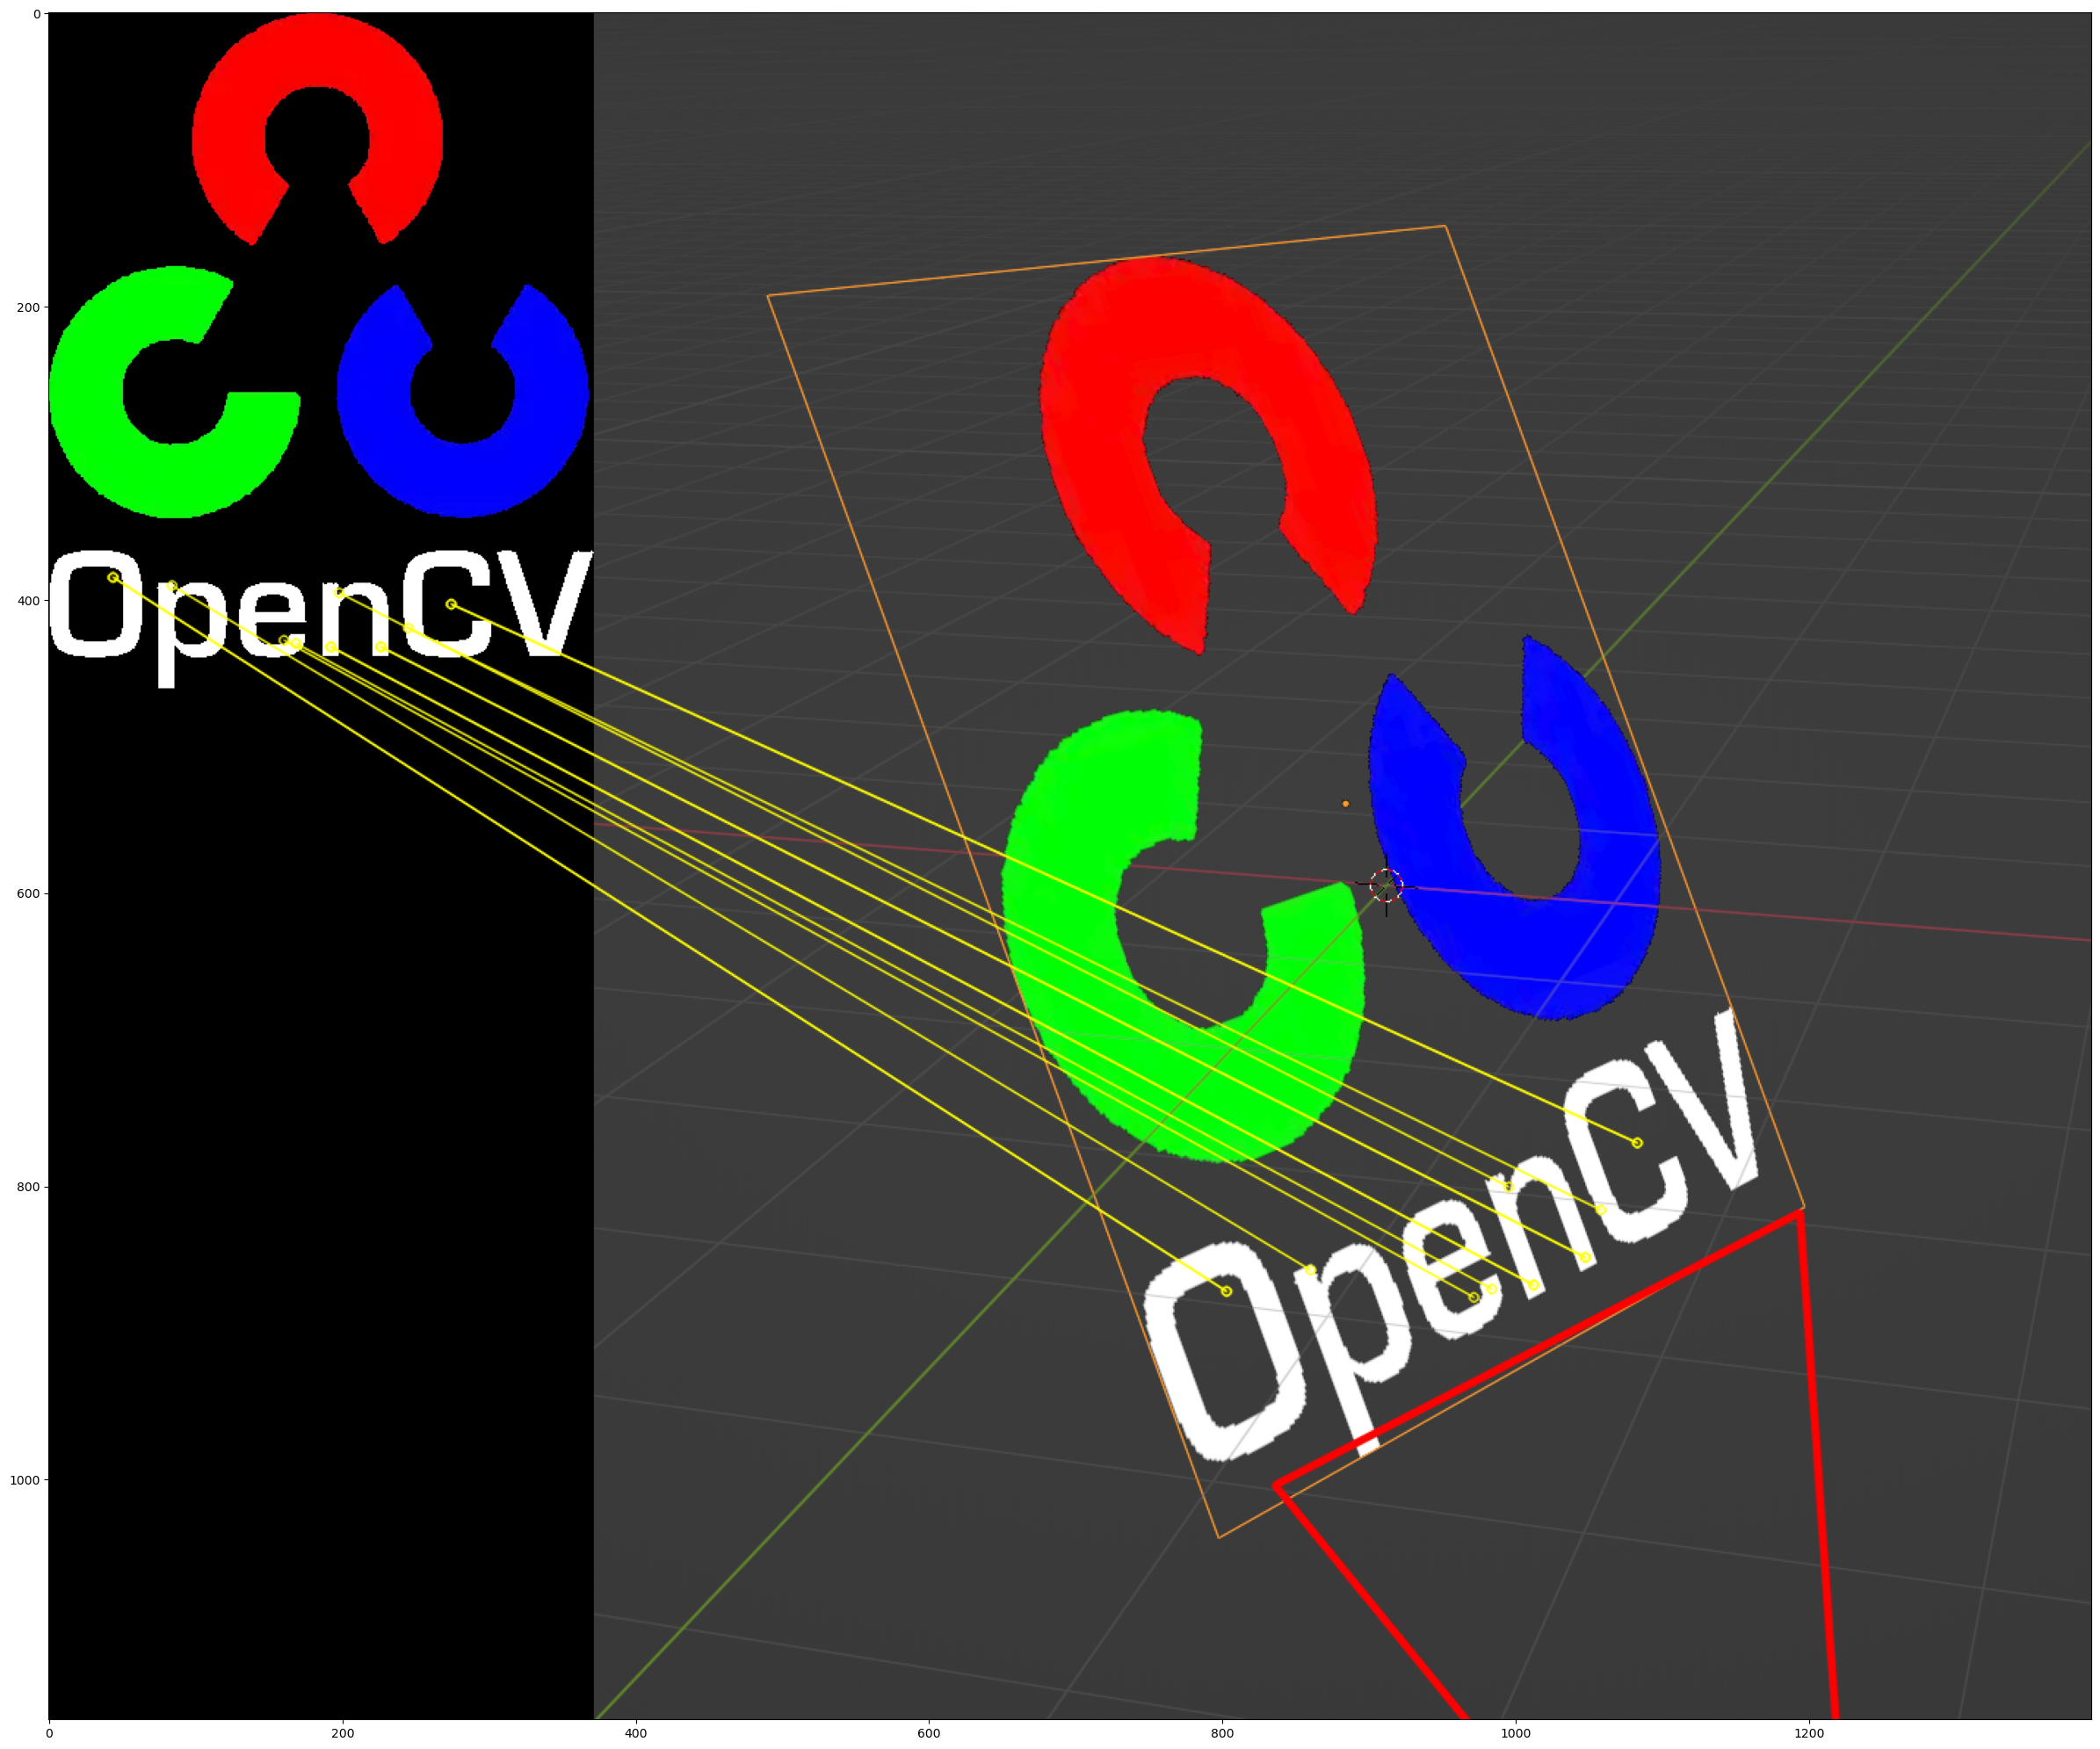

In [26]:
draw_params = dict(matchColor = (255, 255, 0), # 用绿色绘制匹配
                   singlePointColor = None,
                   matchesMask = matchesMask, # 只绘制内部点
                   flags = 2)
dest = cv.drawMatches(img_1,kp1,img_2,kp2,good,None,**draw_params)
showImage(dest, figsize=(30, 30))